In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, label_ranking_average_precision_score

In [2]:
# Load the train and test datasets

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
# Encode the target variable

le = LabelEncoder()
df_train["prognosis"] = le.fit_transform(df_train["prognosis"])
target_names = le.classes_

In [4]:
df_train.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,6


In [5]:
target_names

array(['Chikungunya', 'Dengue', 'Japanese_encephalitis', 'Lyme_disease',
       'Malaria', 'Plague', 'Rift_Valley_fever', 'Tungiasis',
       'West_Nile_fever', 'Yellow_Fever', 'Zika'], dtype=object)

In [6]:
# Train the RandomForest classifier
# Drop the id and target variable
X = df_train.drop(["id", "prognosis"], axis=1)
y = df_train["prognosis"]

rf = RandomForestClassifier(random_state=5)
rf.fit(X, y)

RandomForestClassifier(random_state=5)

In [7]:
# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feature_importances

nose_bleed               0.023952
mouth_bleed              0.022662
coma                     0.022388
joint_pain               0.022298
rash                     0.021946
                           ...   
breathing_restriction    0.005661
lips_irritation          0.005306
finger_inflammation      0.005087
bullseye_rash            0.003346
speech_problem           0.002558
Length: 64, dtype: float64

([<matplotlib.axis.XTick at 0x2039fe57640>,
 [Text(0, 0, 'sudden_fever'),
  Text(1, 0, 'headache'),
  Text(2, 0, 'mouth_bleed'),
  Text(3, 0, 'nose_bleed'),
  Text(4, 0, 'muscle_pain'),
  Text(5, 0, 'joint_pain'),
  Text(6, 0, 'vomiting'),
  Text(7, 0, 'rash'),
  Text(8, 0, 'diarrhea'),
  Text(9, 0, 'hypotension'),
  Text(10, 0, 'pleural_effusion'),
  Text(11, 0, 'ascites'),
  Text(12, 0, 'gastro_bleeding'),
  Text(13, 0, 'swelling'),
  Text(14, 0, 'nausea'),
  Text(15, 0, 'chills'),
  Text(16, 0, 'myalgia'),
  Text(17, 0, 'digestion_trouble'),
  Text(18, 0, 'fatigue'),
  Text(19, 0, 'skin_lesions'),
  Text(20, 0, 'stomach_pain'),
  Text(21, 0, 'orbital_pain'),
  Text(22, 0, 'neck_pain'),
  Text(23, 0, 'weakness'),
  Text(24, 0, 'back_pain'),
  Text(25, 0, 'weight_loss'),
  Text(26, 0, 'gum_bleed'),
  Text(27, 0, 'jaundice'),
  Text(28, 0, 'coma'),
  Text(29, 0, 'diziness'),
  Text(30, 0, 'inflammation'),
  Text(31, 0, 'red_eyes'),
  Text(32, 0, 'loss_of_appetite'),
  Text(33, 0, 'urin

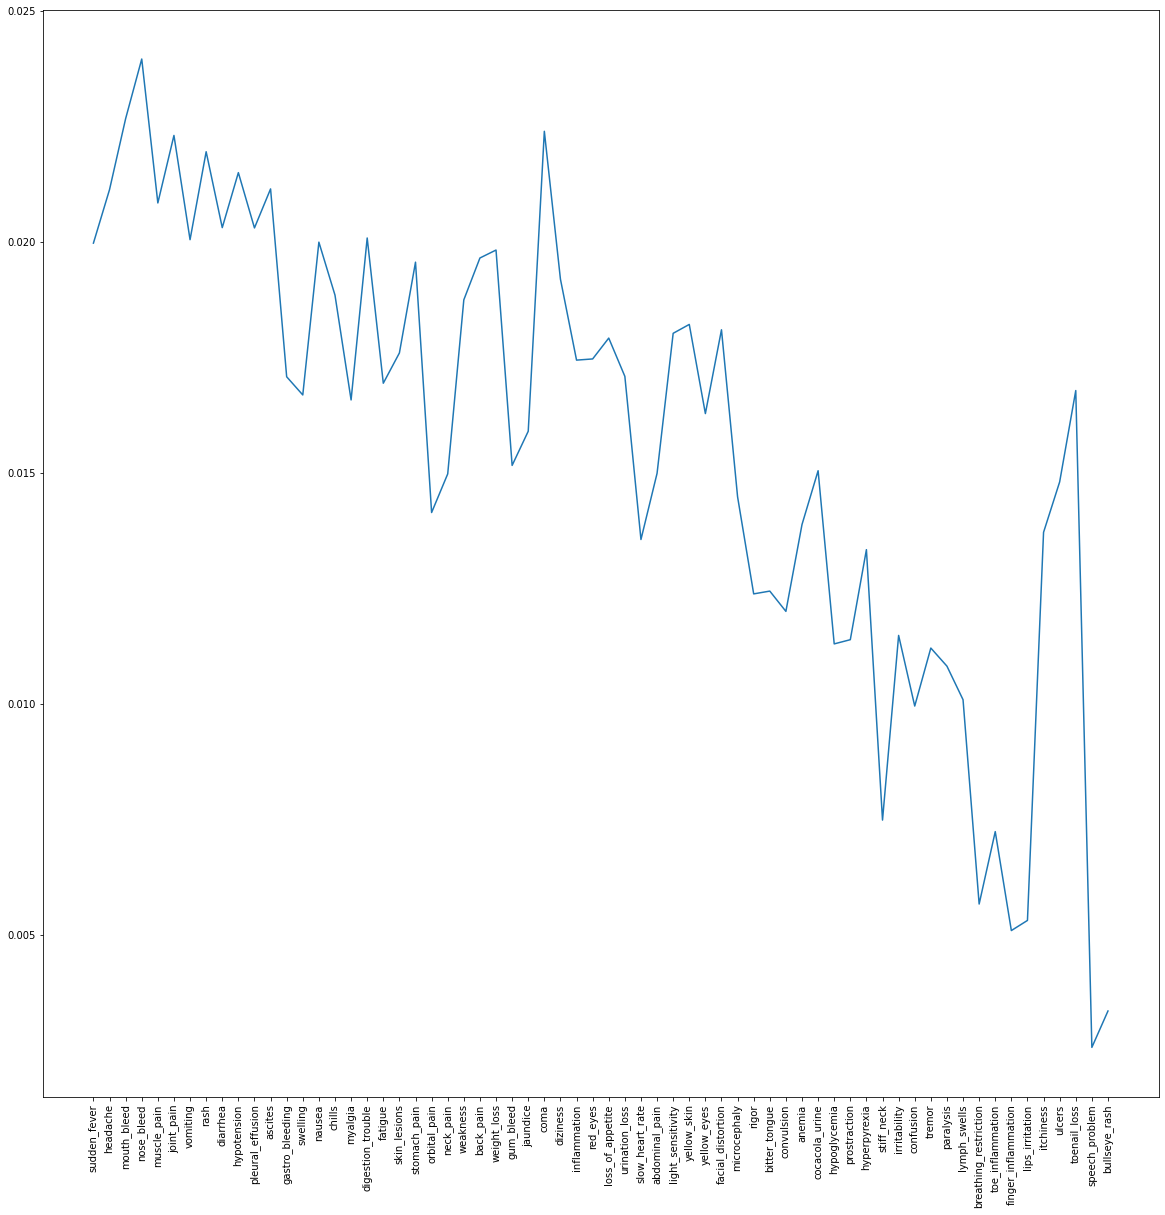

In [8]:
plt.figure(figsize=(20,20))
plt.plot(importances)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90)

In [9]:
# Evaluate the model using MAP@3

y_pred_proba = rf.predict_proba(X)
y_true_one_hot = pd.get_dummies(df_train["prognosis"]).to_numpy()

map3 = label_ranking_average_precision_score(y_true_one_hot, y_pred_proba)
map3

1.0

In [10]:
# Drop the id column
X_test = df_test.drop("id", axis=1)

# Predict probabilities for the test set
y_test_pred_proba = rf.predict_proba(X_test)

# Get the top 3 most likely target indices
top3_indices = np.argsort(-y_test_pred_proba, axis=1)[:, :3]

# Convert the indices back to the original target label
transformed_labels = np.array([le.inverse_transform(row) for row in top3_indices])

# Create a new DataFrame with the id and top 3 targets
results_df = pd.DataFrame({"id": df_test["id"], "prognosis": [" ".join(targets) for targets in transformed_labels]})

# Save the output DataFrame to a CSV file
results_df.to_csv("submissions.csv", index=False)